The goal of this notebook is to count the number of affected guides (for a great many libraries) in the gnomAD 1KG/HGDP dataset.

In [6]:
#Set up the environment
library(tidyverse)
library(reshape2)

In [7]:
#Load in the data
setwd("/home/jupyter/Ancestry/analysis/affected_guides_per_individual")
all.libraries = list.files(path = ".", pattern = "final")
all.libraries

[1] "final_avana.txt"     "final_calabrese.txt" "final_dolcetto.txt" 
[4] "final_gecko.txt"     "final_minlibcas.txt" "final_moffat.txt"   
[7] "final_sanger.txt"

In [8]:
#Load in the library data
setwd("/home/jupyter/Ancestry/analysis/affected_guides_per_individual")
library.data.list = NULL
iteration = 1
for(library in all.libraries){
    
    #Load in the data
    library.data.list[[iteration]] = read.table(library, sep = "\t", header = T)
    
    #update the loop iteration
    iteration = iteration + 1
}

names(library.data.list) = all.libraries

In [9]:
#Calculate the total number of guides in each library
avana.guides = library.data.list[[1]] %>% nrow()
calabrese.guides = library.data.list[[2]] %>% nrow()
dolcetto.guides = library.data.list[[3]] %>% nrow()
gecko.guides = library.data.list[[4]] %>% nrow()
minilibcas.guides = library.data.list[[5]] %>% nrow()
moffatt.guides = library.data.list[[6]] %>% nrow() 
sanger.guides = library.data.list[[7]] %>% nrow()

In [10]:
#Load in the gnomAD annotation file so that we know which sample belongs to each ancestry group
setwd("/home/jupyter/Ancestry/raw_data/hgdp")
sample.annotation = read.table("gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.tsv.bgz", sep = "\t", header = T) %>%
select(s, gnomad_population_inference) %>%
mutate(gnomad_population_inference = gsub("\\..*pop", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("prob..*", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("..*:", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub(",", "", gnomad_population_inference)) %>%
rename("sample" = 1, "ancestry" = 2)

head(sample.annotation)

,sample,ancestry
,<chr>,<chr>
1,CHMI_CHMI3_WGS2,nfe
2,HG00096,nfe
3,HG00097,nfe
4,HG00099,nfe
5,HG00100,nfe
6,HG00101,nfe


In [ ]:
#Get the total number of affected guides for each library
affected.guides.per.individual = NULL
for(i in 1:length(library.data.list)){
    
    #format the library correctly
    df.formatted = library.data.list[[i]] %>%
    select(-seq, -chr, -posL, -posR)
    
    #calculate the number of affected guides per sample
    affected.guides = df.formatted %>% apply(2, sum)
    
    #Return the output outside of the loop
    affected.guides.per.individual = cbind(affected.guides.per.individual, affected.guides)
    
}

#Get a vector of sample names
sample.names = library.data.list[[1]] %>% names() %>% .[! . %in% c("seq", "chr", "posL", "posR")]

#Now format the data frame correctly
affected.guides.df = affected.guides.per.individual %>%
data.frame() %>%
rownames_to_column("sample") %>%
rename_with(~ c(all.libraries), starts_with("affected.guides")) %>%
inner_join(sample.annotation) 

head(affected.guides.df)

In [7]:
#Write affected.guides.df so that we don't need to re-load all of the data each time
setwd("/home/jupyter/Ancestry/analysis/affected_guides_per_individual")
write.table(affected.guides.df, "affected_guides_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [11]:
#Re-load the data
setwd("/home/jupyter/Ancestry/analysis/affected_guides_per_individual")
affected.guides.df = read.table("affected_guides_df.txt", sep = "\t", header = T)

In [12]:
#Convert it so that it is the percent of the library that is affected
percent.affected.df = affected.guides.df %>%
mutate("avana" = (final_avana.txt/avana.guides)*100) %>%
mutate("calabrese" = (final_calabrese.txt/calabrese.guides)*100) %>%
mutate("dolcetto" = (final_dolcetto.txt/dolcetto.guides)*100) %>%
mutate("gecko" = (final_gecko.txt/gecko.guides)*100) %>%
mutate("minlibcas" = (final_minlibcas.txt/minilibcas.guides)*100) %>%
mutate("moffatt" = (final_moffat.txt/moffatt.guides)*100) %>%
mutate("sanger" = (final_sanger.txt/sanger.guides)*100) %>%
select(-final_avana.txt, -final_calabrese.txt, -final_dolcetto.txt, -final_gecko.txt, -final_minlibcas.txt, -final_moffat.txt, -final_sanger.txt)

head(percent.affected.df)

,sample,ancestry,avana,calabrese,dolcetto,gecko,minlibcas,moffatt,sanger
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CHMI_CHMI3_WGS2,nfe,1.761821,3.662859,3.296401,1.918991,1.514856,0.1391636,0.5279863
2,HGDP00843,amr,1.702291,3.469630,3.045791,1.824445,1.356130,0.1494177,0.5829213
3,HGDP00392,sas,1.788752,3.629868,3.317285,1.904949,1.551057,0.1494177,0.5340902
4,HGDP00544,oth,1.825604,3.759002,3.520631,1.990134,1.623458,0.2314510,0.6866874
5,HGDP01053,amr,1.706543,3.609132,3.213964,1.820701,1.448024,0.1391636,0.5829213
6,HGDP00191,sas,1.754734,3.545036,3.326079,1.933968,1.534349,0.1376987,0.6073369


Using sample, ancestry as id variables



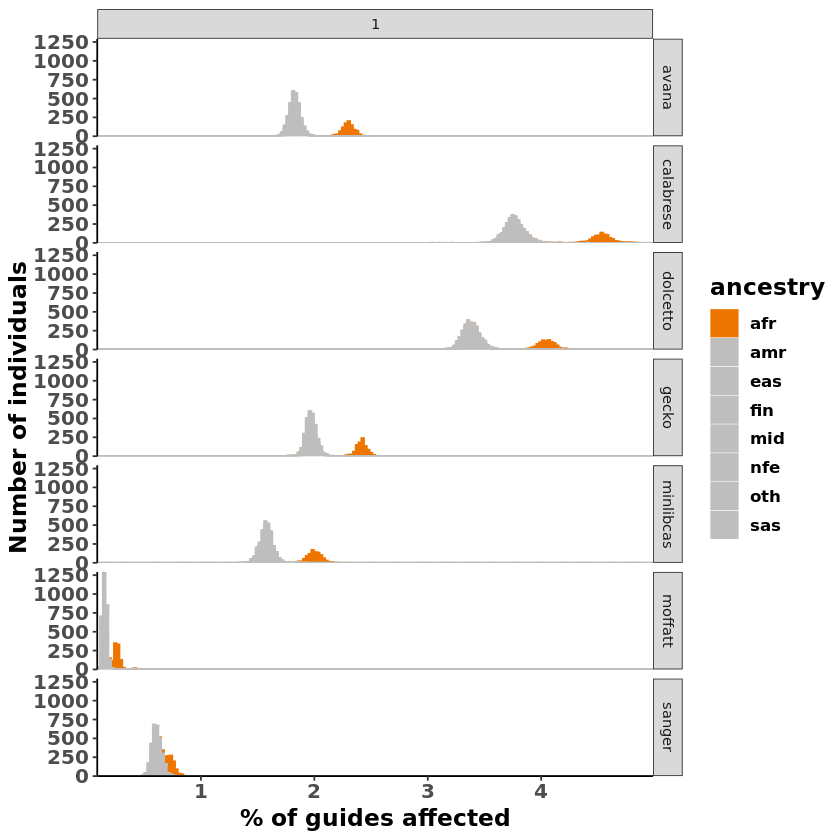

In [10]:
#Plot the data
percent.affected.df %>%
melt() %>%
filter(ancestry != "NA") %>%
ggplot() +
geom_histogram(aes(x = value, color = ancestry, fill = ancestry), bins = 200) +
facet_grid(variable ~ 1, scales = "free_x") +
theme_bw() +

scale_color_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +
scale_fill_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +


theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) +

ylab("Number of individuals") +
xlab("% of guides affected")

#Put the exported image into the google bucket
setwd("/home/jupyter/Ancestry/analysis/affected_guides_per_individual")
ggsave("affected_guides_per_individual.pdf", width = 5, height = 7)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/affected_guides_per_individual
gsutil cp affected_guides_per_individual.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Let's calculate the differential in peak median for all libraries (afr vs other)

In [10]:
#avana
afr.median.avana = percent.affected.df %>% filter(ancestry %in% "afr") %>% pull(avana) %>% median()
other.median.avana = percent.affected.df %>% filter(ancestry != "afr") %>% pull(avana) %>% median()

#calabrese
afr.median.calabrese = percent.affected.df %>% filter(ancestry %in% "afr") %>% pull(calabrese) %>% median()
other.median.calabrese = percent.affected.df %>% filter(ancestry != "afr") %>% pull(calabrese) %>% median()

#dolcetto
afr.median.dolcetto = percent.affected.df %>% filter(ancestry %in% "afr") %>% pull(dolcetto) %>% median()
other.median.dolcetto = percent.affected.df %>% filter(ancestry != "afr") %>% pull(dolcetto) %>% median()

#gecko
afr.median.gecko = percent.affected.df %>% filter(ancestry %in% "afr") %>% pull(gecko) %>% median()
other.median.gecko = percent.affected.df %>% filter(ancestry != "afr") %>% pull(gecko) %>% median()

#minlibcas
afr.median.minlibcas = percent.affected.df %>% filter(ancestry %in% "afr") %>% pull(minlibcas) %>% median()
other.median.minlibcas = percent.affected.df %>% filter(ancestry != "afr") %>% pull(minlibcas) %>% median()

#moffatt
afr.median.moffatt = percent.affected.df %>% filter(ancestry %in% "afr") %>% pull(moffatt) %>% median()
other.median.moffatt = percent.affected.df %>% filter(ancestry != "afr") %>% pull(moffatt) %>% median()

#sanger
afr.median.sanger = percent.affected.df %>% filter(ancestry %in% "afr") %>% pull(sanger) %>% median()
other.median.sanger = percent.affected.df %>% filter(ancestry != "afr") %>% pull(sanger) %>% median()

#Calculate the ratios
avana.ratio = afr.median.avana/other.median.avana
calabrese.ratio = afr.median.calabrese/other.median.calabrese
dolcetto.ratio = afr.median.dolcetto/other.median.dolcetto
gecko.ratio = afr.median.gecko/other.median.gecko
minlibcas.ratio = afr.median.minlibcas/other.median.minlibcas
moffatt.ratio = afr.median.moffatt/other.median.moffatt
sanger.ratio = afr.median.sanger/other.median.sanger

#Print the output
avana.ratio
calabrese.ratio
dolcetto.ratio
gecko.ratio
minlibcas.ratio
moffatt.ratio
sanger.ratio


[1] 1.261072

[1] 1.205963

[1] 1.197788

[1] 1.227424

[1] 1.270318

[1] 1.718447

[1] 1.212121

# Add in the random NGG and the AF library

For the paper figure let's generate a modified version of this figure that has the random NGG library at the top and the AF library at the bottom.

In [13]:
###First, let's get all of the random NGG data ready.

#Read it back in (for downstream analysis and for re-making the figure)
setwd("/home/jupyter/Ancestry/analysis/random_ngg")
affected.guides.df = read.table("affected_guides_per_gnomad_sample.txt", sep = "\t", header = T)

#Load in the gnomAD annotation file so that we know which sample belongs to each ancestry group
setwd("/home/jupyter/Ancestry/raw_data/hgdp")
sample.annotation = read.table("gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.tsv.bgz", sep = "\t", header = T) %>%
select(s, gnomad_population_inference) %>%
mutate(gnomad_population_inference = gsub("\\..*pop", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("prob..*", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("..*:", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub(",", "", gnomad_population_inference)) %>%
rename("sample" = 1, "ancestry" = 2)

#Calculate the number of guides in the library
tot.guides = 1000000

#Assemble everything into a single data frame
affected.guides.df = affected.guides.df %>%
rename("sample" = 1, "num_guides" = 2) %>%
inner_join(sample.annotation, by = "sample") %>%
mutate(num_guides = as.numeric(num_guides)) %>%
filter(ancestry != "NA") %>%
mutate(percent_guides = (num_guides/tot.guides)*100)

head(affected.guides.df)

,sample,num_guides,ancestry,percent_guides
,<chr>,<dbl>,<chr>,<dbl>
1,CHMI_CHMI3_WGS2,17505,nfe,1.7505
2,HGDP00843,16180,amr,1.6180
3,HGDP00392,17767,sas,1.7767
4,HGDP00544,18004,oth,1.8004
5,HGDP01053,16498,amr,1.6498
6,HGDP00191,17306,sas,1.7306


In [14]:
###Second, let's get all of the AF library ready.

#Load in Aaron's data
setwd("/home/jupyter/Ancestry/analysis/aaron_custom_guide_library")
custom.guides = read.table("final_custom_library.txt", header = T)
head(custom.guides)

#Calculate the number of guides in the library
tot.guides.af = nrow(custom.guides)

#calculate the number of affected guides per individual
guides.per.person = custom.guides %>%
select(-seq, -chr, -posL, -posR) %>%
apply(2, sum)
head(guides.per.person)

#Get a vector of the names
sample.names = colnames(custom.guides)[5:ncol(custom.guides)]
head(sample.names)

#Assemble everything into a single data frame
affected.guides.af.df = cbind(sample.names, guides.per.person) %>%
data.frame() %>%
rename("sample" = 1, "num_guides" = 2) %>%
inner_join(sample.annotation, by = "sample") %>%
mutate(num_guides = as.numeric(num_guides)) %>%
filter(ancestry != "NA") %>%
mutate(percent_guides = (num_guides/tot.guides.af)*100)

length(sample.names)
head(affected.guides.af.df)

,seq,chr,posL,posR,CHMI_CHMI3_WGS2,LP6005441.DNA_F08,HGDP00843,HGDP00392,LP6005441.DNA_H03,HGDP00544,⋯,HG00288,HG00290,HG00304,HG01765,HG01766,HG01767,HG01768,HG01785,HG01786,HG02219
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,AAAACTGCTACAATACTCCA,chr22,49925465,49925487,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,AAACACACCCAGCATCAACC,chr22,50423557,50423579,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,AAACACGATCAGGTCAATTC,chr22,41945939,41945961,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AAAGAGGACAGCTCTGACAA,chr22,15695464,15695486,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AAAGCAGCAGCATCCATGGT,chr22,21047999,21048021,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,AAAGCCGTCCTGTCCGACAT,chr22,39374523,39374545,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


CHMI_CHMI3_WGS2 LP6005441.DNA_F08         HGDP00843         HGDP00392 
              150               186               152               167 
LP6005441.DNA_H03         HGDP00544 
              165               200

[1] "CHMI_CHMI3_WGS2"   "LP6005441.DNA_F08" "HGDP00843"        
[4] "HGDP00392"         "LP6005441.DNA_H03" "HGDP00544"

[1] 4151

,sample,num_guides,ancestry,percent_guides
,<chr>,<dbl>,<chr>,<dbl>
1,CHMI_CHMI3_WGS2,150,nfe,0.2035831
2,HGDP00843,152,amr,0.2062975
3,HGDP00392,167,sas,0.2266558
4,HGDP00544,200,oth,0.2714441
5,HGDP01053,169,amr,0.2293702
6,HGDP00191,173,sas,0.2347991


In [15]:
#Grab the useful information from both of the data frames
random.ngg = affected.guides.df %>%
select(sample, percent_guides)

af.library = affected.guides.af.df %>%
select(sample, percent_guides)


#Then merge them with percent.affected.df
complete.df = percent.affected.df %>%
inner_join(random.ngg, by = "sample") %>%
inner_join(af.library, by = "sample") %>%
rename("random_ngg" = 9, "af_lib" = 10) %>%
relocate(random_ngg, .before = avana)

head(complete.df)

#set up a vector of factors so that everything is ordered properly
factor.vector = c("random_ngg", "avana", "calabrese", "dolcetto", "gecko", "minlibcas", "moffatt", "sanger", "af_lib")

,sample,ancestry,random_ngg,avana,calabrese,dolcetto,gecko,minlibcas,moffatt,af_lib,percent_guides.y
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CHMI_CHMI3_WGS2,nfe,0.5279863,1.761821,3.662859,3.296401,1.918991,1.514856,0.1391636,1.7505,0.2035831
2,HGDP00843,amr,0.5829213,1.702291,3.469630,3.045791,1.824445,1.356130,0.1494177,1.6180,0.2062975
3,HGDP00392,sas,0.5340902,1.788752,3.629868,3.317285,1.904949,1.551057,0.1494177,1.7767,0.2266558
4,HGDP00544,oth,0.6866874,1.825604,3.759002,3.520631,1.990134,1.623458,0.2314510,1.8004,0.2714441
5,HGDP01053,amr,0.5829213,1.706543,3.609132,3.213964,1.820701,1.448024,0.1391636,1.6498,0.2293702
6,HGDP00191,sas,0.6073369,1.754734,3.545036,3.326079,1.933968,1.534349,0.1376987,1.7306,0.2347991


Using sample, ancestry as id variables



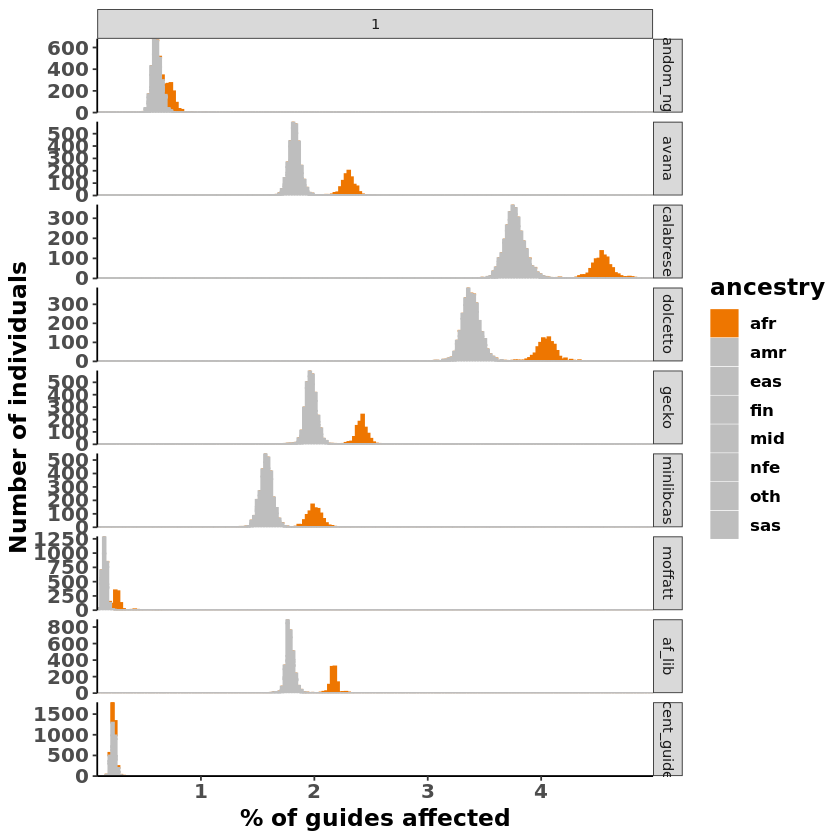

In [17]:
complete.df %>%
melt() %>%
filter(ancestry != "NA") %>%
ggplot() +
geom_histogram(aes(x = value, color = ancestry, fill = ancestry), bins = 200) +
facet_grid(variable ~ 1, scales = "free") +
theme_bw() +

scale_color_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +
scale_fill_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +


theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) +

ylab("Number of individuals") +
xlab("% of guides affected")


#Put the exported image into the google bucket
setwd("/home/jupyter/Ancestry/analysis/affected_guides_per_individual")
ggsave("affected_guides_per_individual.complete.pdf", width = 5, height = 7)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/affected_guides_per_individual
gsutil cp affected_guides_per_individual.complete.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Create variants of the figure where Moffatt, Sanger, and Custom Library are in a different figure (with a custom x-axis scale)

Using sample, ancestry as id variables

Warning message:
“Removed 144 rows containing missing values (geom_bar).”
Warning message:
“Removed 144 rows containing missing values (geom_bar).”


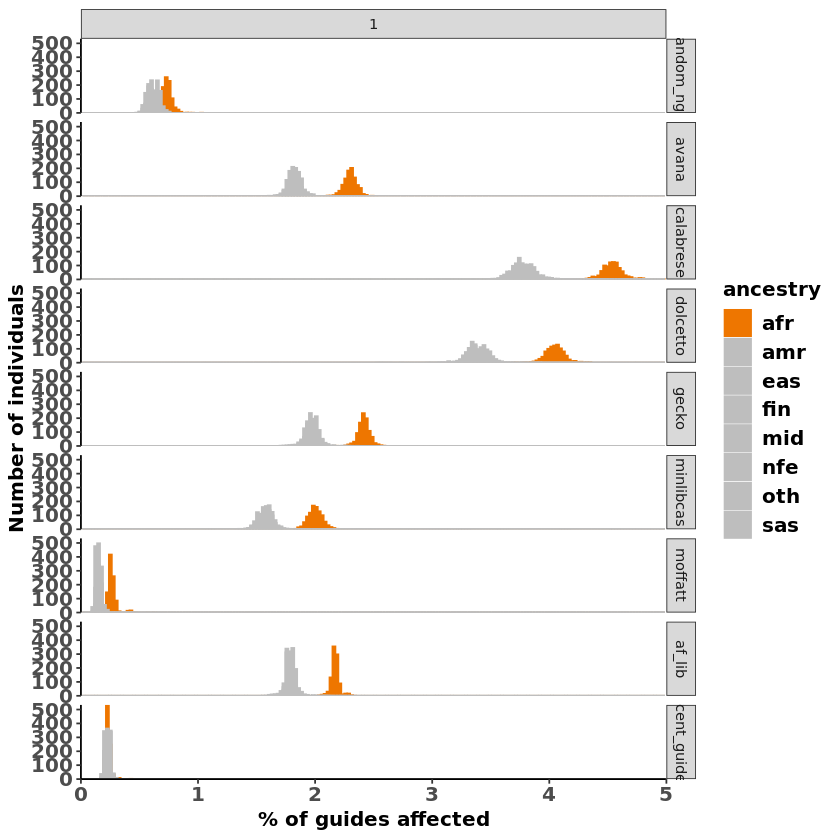

In [18]:
complete.df %>%
melt() %>%
filter(ancestry != "NA") %>%
ggplot() +
geom_histogram(aes(x = value, color = ancestry, fill = ancestry), bins = 200, position = "identity") +
facet_grid(variable ~ 1) +
theme_bw() +

scale_color_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +
scale_fill_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 12, face = "bold"),
axis.title.y = element_text(color = "black", size = 12, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 12,face = "bold")
) +


theme(
legend.title = element_text(size = 12, face = "bold"),
legend.text = element_text(size = 12, face = "bold")
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0), limits = c(0, 5)) +

ylab("Number of individuals") +
xlab("% of guides affected")


#Put the exported image into the google bucket
setwd("/home/jupyter/Ancestry/analysis/affected_guides_per_individual")
ggsave("affected_guides_per_individual.top.pdf", width = 5, height = 7)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/affected_guides_per_individual
gsutil cp affected_guides_per_individual.top.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Using sample, ancestry as id variables

Warning message:
“Removed 24061 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 48 rows containing missing values (geom_bar).”
Warning message:
“Removed 24061 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 48 rows containing missing values (geom_bar).”


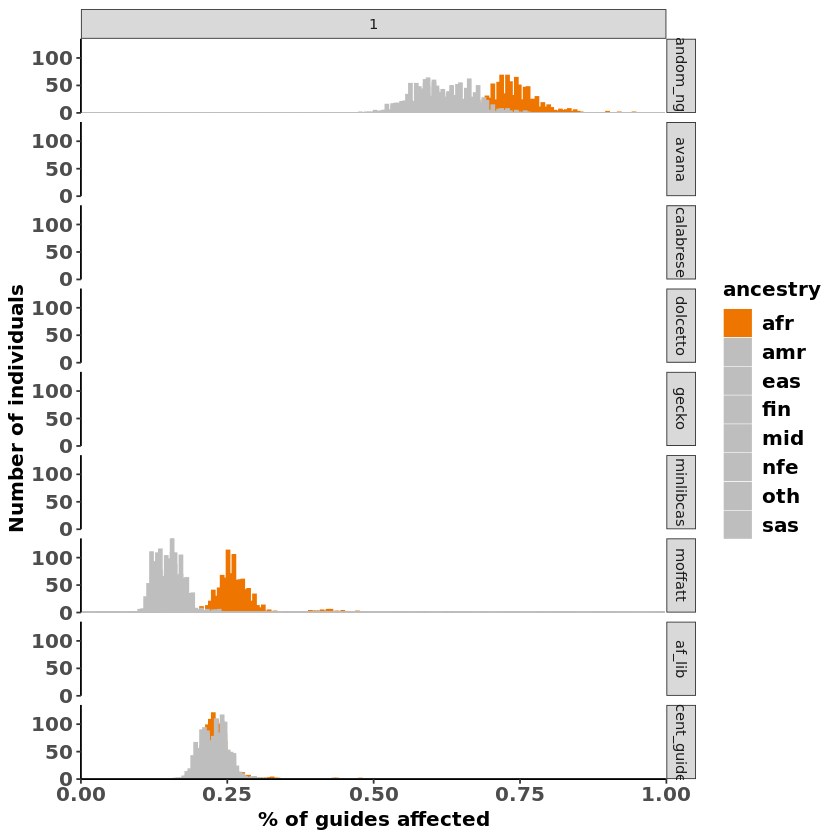

In [19]:
complete.df %>%
melt() %>%
filter(ancestry != "NA") %>%
ggplot() +
geom_histogram(aes(x = value, color = ancestry, fill = ancestry), bins = 200, position = "identity") +
facet_grid(variable ~ 1) +
theme_bw() +

scale_color_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +
scale_fill_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 12, face = "bold"),
axis.title.y = element_text(color = "black", size = 12, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 12,face = "bold")
) +


theme(
legend.title = element_text(size = 12, face = "bold"),
legend.text = element_text(size = 12, face = "bold")
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0), limits = c(0,1)) +

ylab("Number of individuals") +
xlab("% of guides affected")


#Put the exported image into the google bucket
setwd("/home/jupyter/Ancestry/analysis/affected_guides_per_individual")
ggsave("affected_guides_per_individual.bottom.pdf", width = 5, height = 7)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/affected_guides_per_individual
gsutil cp affected_guides_per_individual.bottom.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Calculate the AFR/Other ratio for all libraries

In [16]:
#calculate the median for african and other
african.medians = complete.df %>%
select(-sample) %>%
filter(ancestry %in% "afr") %>%
select(-ancestry) %>%
apply(2, median)

other.medians = complete.df %>%
select(-sample) %>%
filter(ancestry != "afr") %>%
select(-ancestry) %>%
apply(2, median)

african.medians
other.medians

differential.median = african.medians/other.medians

differential.median

random_ngg            avana        calabrese         dolcetto 
       0.7324666        2.3004309        4.5366286        4.0471323 
           gecko        minlibcas          moffatt           af_lib 
       2.4174600        2.0021720        0.2592837        2.1699500 
percent_guides.y 
       0.2293702

random_ngg            avana        calabrese         dolcetto 
       0.6042849        1.8241864        3.7618294        3.3788388 
           gecko        minlibcas          moffatt           af_lib 
       1.9695395        1.5761187        0.1508826        1.7805000 
percent_guides.y 
       0.2266558

random_ngg            avana        calabrese         dolcetto 
        1.212121         1.261072         1.205963         1.197788 
           gecko        minlibcas          moffatt           af_lib 
        1.227424         1.270318         1.718447         1.218731 
percent_guides.y 
        1.011976

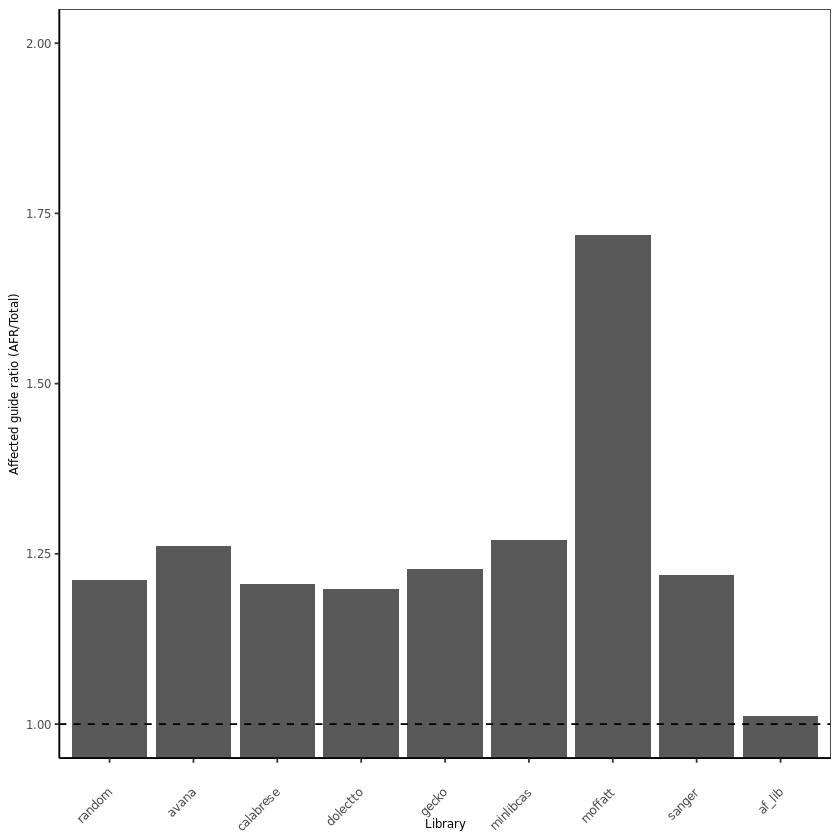

In [29]:
###Make a plotarronie for Figure 3 of the paper
library.name.vector = c("random", "avana", "calabrese", "dolectto", "gecko", "minlibcas", "moffatt", "sanger", "af_lib")

#Bind the two columns together
#And plot the plot
cbind(library.name.vector, differential.median) %>% 
data.frame() %>%
rename("library" = 1, "differential" = 2) %>%
mutate(library = factor(library, levels = library.name.vector)) %>%
mutate(differential = as.numeric(differential)) %>%
ggplot(aes(x = library, y = differential)) +
geom_bar(stat = "identity") +

geom_hline(yintercept = 1, linetype = 2) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +


theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("Affected guide ratio (AFR/Total)") +
xlab("Library") +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 1)
) +

coord_cartesian(ylim = c(1, 2))

#Put the exported image into the google bucket
setwd("/home/jupyter/Ancestry/analysis/affected_guides_per_individual")
ggsave("affected_guide_ratio_bar_plot.pdf", width = 3, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/affected_guides_per_individual
gsutil cp affected_guide_ratio_bar_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [21]:
#Calculate the median number of affected guides across all samples in each library
affected.per.library = percent.affected.df %>%
select(-ancestry) %>%
melt(id = "sample") %>%
group_by(variable) %>%
summarise("percent_affected" = median(value))

affected.per.library

variable,percent_affected
<fct>,<dbl>
avana,1.8454473
calabrese,3.7976473
dolcetto,3.4140122
gecko,1.9891975
minlibcas,1.5983960
moffatt,0.1582070
sanger,0.6256485


In [15]:
#Calculate the affected guide range for avana
affected.guide.min = percent.affected.df %>%
select(-ancestry) %>%
melt(id = "sample") %>%
group_by(variable) %>%
summarise("min" = min(value))

affected.guide.max = percent.affected.df %>%
select(-ancestry) %>%
melt(id = "sample") %>%
group_by(variable) %>%
summarise("min" = max(value))

affected.guide.min
affected.guide.max

variable,min
<fct>,<dbl>
avana,1.1721851
calabrese,2.7146250
dolcetto,2.3676054
gecko,1.3142745
minlibcas,1.0052630
moffatt,0.0644547
sanger,0.3570775


variable,min
<fct>,<dbl>
avana,2.5201270
calabrese,4.9730423
dolcetto,4.3483040
gecko,2.5864248
minlibcas,2.2527916
moffatt,0.6342928
sanger,1.0224013
